### Import Modules

In [1]:
import pickle 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys, os, nilearn
sys.path.append("..")
from lpp_utils import *
from nilearn import datasets, plotting
import nilearn.connectome
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import multipletests


#### Loop across runs, compute within- and across language ISC

In [2]:
result_within = []
result_across = []

n_perm = 500
print(n_perm)

result_all_runs = []
curr_target_size = 2772

data_fr = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/fr_fmriall_resampled.npy")
data_cn = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/cn_fmriall_resampled.npy")
data_en = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/en_fmriall_resampled.npy")
    
n_regions =   data_fr.shape[1]
print(n_regions)
    
all_data = np.concatenate([data_fr, data_cn, data_en], axis =2)

result_all = lpp_isc(all_data[:,:,:], pairwise=True)  
result_within_lang = np.zeros((n_regions,1))
result_across_lang = np.zeros((n_regions,1))

surr_result_within_lang = np.zeros((n_perm, n_regions))
surr_result_across_lang = np.zeros((n_perm, n_regions))

observed_all, distribution = phaseshift_isc_pairwise(all_data[: ,:,:], 
                                           pairwise=True,
                                           summary_statistic= None,
                                           n_shifts= n_perm)


for curr_region in range(n_regions): 
        print(curr_region)
        resmat = squareform(observed_all[:,curr_region])

        w_f = nilearn.connectome.sym_matrix_to_vec(resmat[0:27, 0:27], discard_diagonal=True)
        w_c = nilearn.connectome.sym_matrix_to_vec(resmat[27:60, 27:60], discard_diagonal=True)
        w_e = nilearn.connectome.sym_matrix_to_vec(resmat[60:110, 60:110], discard_diagonal=True)
        
        a_ec = resmat[27:60, 0:27].flatten()
        a_fc = resmat[60:110, 0:27].flatten()
        a_ef = resmat[60:110, 27:60].flatten()

        result_within_lang[curr_region] = np.concatenate([w_f, w_c, w_e]).mean()
        result_across_lang[curr_region] = np.concatenate([a_ec, a_fc, a_ef]).mean()   
        
        # aggregate within/across for the surrogate data
        for curr_perm in range(n_perm):
            resmat = squareform(distribution[curr_perm, :, curr_region])   #(20, 5995, 293)
        
            w_f = nilearn.connectome.sym_matrix_to_vec(resmat[0:27, 0:27], discard_diagonal=True)
            w_c = nilearn.connectome.sym_matrix_to_vec(resmat[27:60, 27:60], discard_diagonal=True)
            w_e = nilearn.connectome.sym_matrix_to_vec(resmat[60:110, 60:110], discard_diagonal=True)

            a_ec = resmat[27:60, 0:27].flatten()
            a_fc = resmat[60:110, 0:27].flatten()
            a_ef = resmat[60:110, 27:60].flatten() 
            
            surr_result_within_lang[curr_perm, curr_region] = np.concatenate([w_f, w_c, w_e]).mean()
            surr_result_across_lang[curr_perm, curr_region] = np.concatenate([a_ec, a_fc, a_ef]).mean()   
    
result_within.append(result_within_lang)
result_across.append(result_across_lang)
    
result_within = np.squeeze(np.asarray(result_within))
result_across = np.squeeze(np.asarray(result_across))

500
293
Assuming 110 subjects with 2772 time points and 293 voxel(s) or ROI(s).
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
25

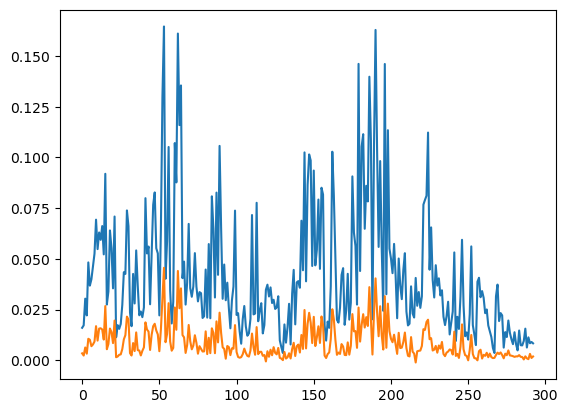

In [4]:
result_within = result_within.reshape((1,293))
result_across = result_across.reshape((1,293))

plt.plot(result_within.T);
plt.plot(result_across.T);

In [5]:
p_values_within = np.zeros(293)
p_values_across = np.zeros(293)

for curr_region in range(293):

    p_values_within[curr_region] = p_from_null(result_within[0,curr_region], 
                                            surr_result_within_lang[:,curr_region],
                                            side='two-sided', exact=False)
    p_values_across[curr_region] = p_from_null(result_within[0,curr_region], 
                                            surr_result_within_lang[:,curr_region],
                                            side='two-sided', exact=False)
    

In [6]:
stats_threshold = 0.05

q = multipletests(p_values_within, method='fdr_by')[1]
corrected_within_true = q  < stats_threshold
corrected_within = np.zeros(result_within[0,:].shape)
corrected_within[corrected_within_true] = result_within[0, corrected_within_true]
corrected_within.shape

q = multipletests(p_values_across, method='fdr_by')[1]
corrected_across_true = q  < stats_threshold
corrected_across = np.zeros(result_across[0,:].shape)
corrected_across[corrected_across_true] = result_across[0, corrected_across_true]
corrected_across.shape
  

(293,)

In [7]:
file = open('../../data_lpp/fmri_data/other/all293_masker_pickled.obj', 'rb') 
all293_masker_reopened = pickle.load(file)
file.close();
all293_masker_reopened

NiftiLabelsMasker(detrend=True, high_pass=0.01,
                  labels_img='../../data_lpp/fmri_data/other/allcombined.nii',
                  low_pass=0.12, standardize=True, t_r=2.0)

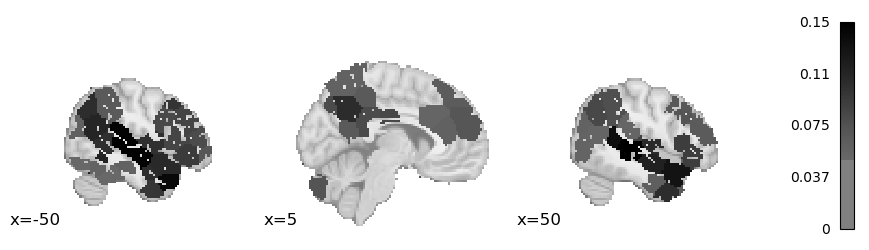

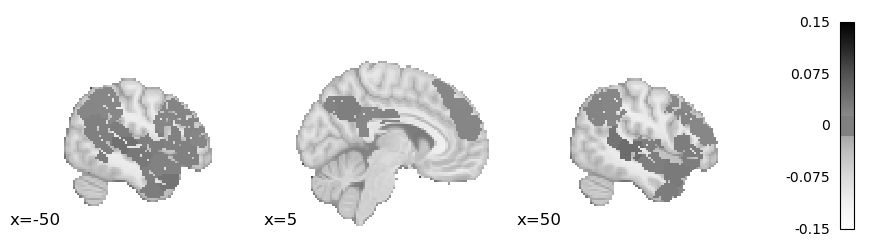

In [8]:
val_v_max = 0.15
slices_to_plot = [-50, 5, 50]

plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(corrected_within, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Greys',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.05,  vmax = val_v_max,
                      );



val_v_max = 0.15
slices_to_plot = [-50, 5, 50]
plotting.plot_stat_map( all293_masker_reopened.inverse_transform(np.reshape(corrected_across, (1, 293))), 
                            colorbar = True, annotate = True,
                            cmap = 'Greys',   
                            display_mode = "x", cut_coords = slices_to_plot, 
                            threshold = 0.015,  vmax = val_v_max,
                      );


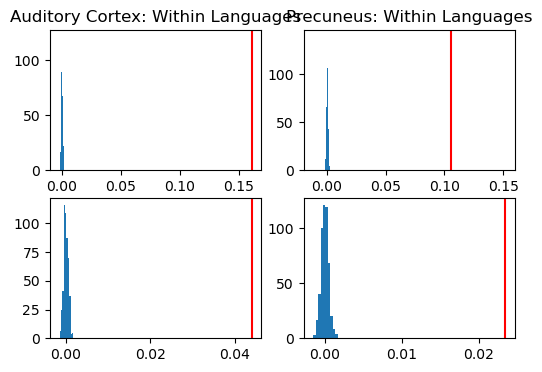

In [9]:
plt.figure(figsize = (6,4));

plt.subplot(2,2,1);
region = 62;
plt.hist(surr_result_within_lang[:,region]);
plt.axvline(result_within[0,region], color = 'r');
plt.title('Auditory Cortex: Within Languages');
#plt.xlim([-0.02, 0.1])

plt.subplot(2,2,3);
plt.hist(surr_result_across_lang[:,region]);
plt.axvline(result_across[0,region], color = 'r');
#plt.title('Auditory Cortex: Across Languages')


plt.subplot(2,2,2);
region = 89;
plt.hist(surr_result_within_lang[:,region]);
plt.axvline(result_within[0,region], color = 'r');
plt.title('Precuneus: Within Languages');
plt.xlim([-0.02, 0.16])


plt.subplot(2,2,4);
plt.hist(surr_result_across_lang[:,region]);
plt.axvline(result_across[0,region], color = 'r');
#plt.title('Precuneus: Across Languages')


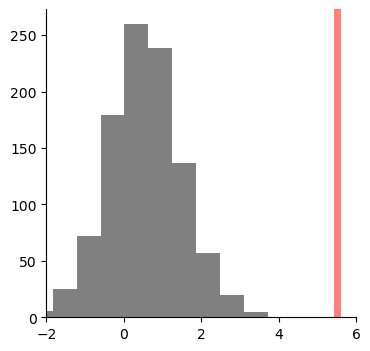

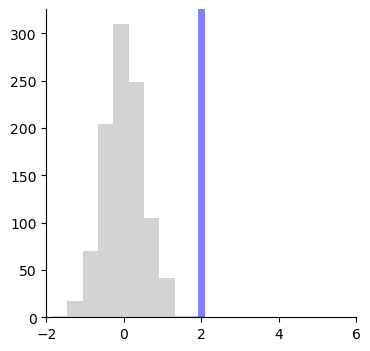

In [11]:
import seaborn as sns
plt.figure(figsize = (4,4))
plt.hist(np.random.randn(1000)+0.5, color = 'gray')
plt.axvline(3+2.5, color = 'red', linewidth = 5, alpha = 0.5)
plt.xlim([-2,6])
sns.despine()

plt.figure(figsize = (4,4))
plt.hist(np.random.randn(1000)/2 , color = 'lightgrey', )
plt.axvline(2, color = 'blue', linewidth = 5, alpha = 0.5)
plt.xlim([-2,6])
sns.despine()

### Explore individual results

In [12]:
d = np.load('../../data_lpp/fmri_data/other/shen_pauli_aan_dict.npy', allow_pickle=True).item()
#### print(d[63]) #['data_array_index']

file = open('../../data_lpp/fmri_data/other/all293_masker_pickled.obj', 'rb') 
all293_masker_reopened = pickle.load(file)
file.close();
all293_masker_reopened

NiftiLabelsMasker(detrend=True, high_pass=0.01,
                  labels_img='../../data_lpp/fmri_data/other/allcombined.nii',
                  low_pass=0.12, standardize=True, t_r=2.0)

{'coords': [39.788649706457925, -25.643835616438352, 14.450097847358123], 'name': "31.31% Parietal_Operculum_Cortex; 24.07% Planum_Temporale; 21.33% Heschl's_Gyrus_(includes_H1_and_H2); 21.33% Insular_Cortex", 'index_label': 62, 'data_array_index': 61}
(308, 293, 27)
(308, 293, 33)
(308, 293, 50)
(5995, 293)
61
(308, 293, 50)
(308, 293, 27)
(308, 293, 33)
13
16
25
0.5798024434496136
0.7237911785918943
0.7022787797610521


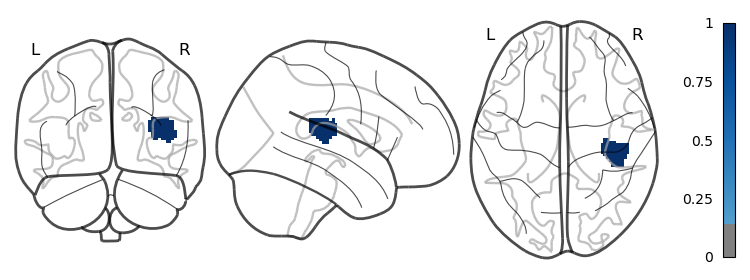

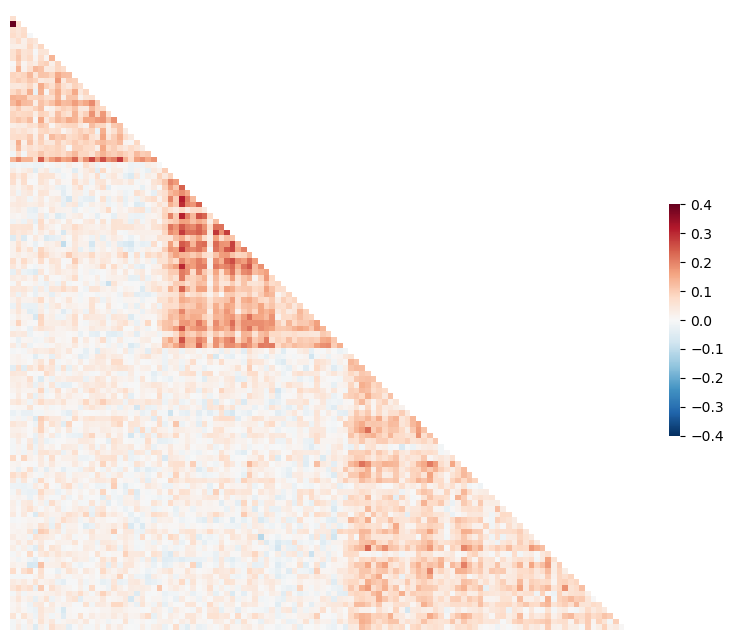

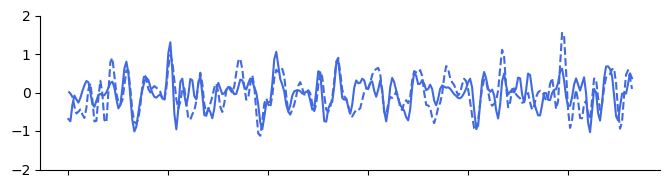

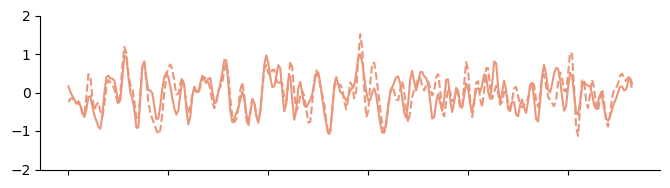

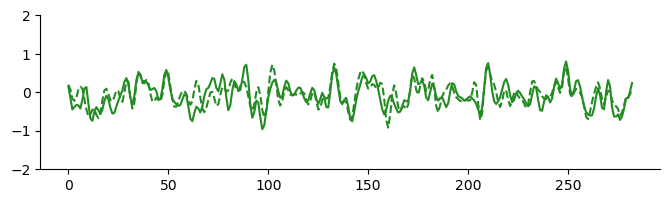

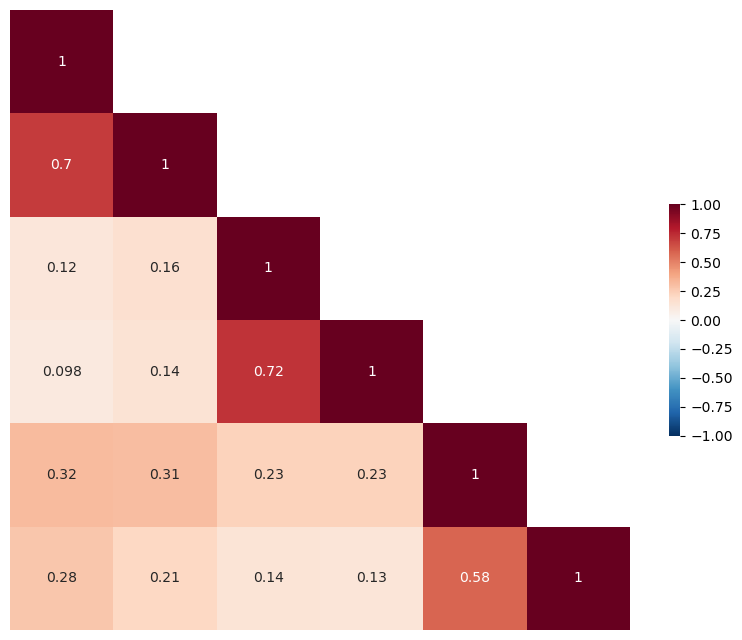

In [13]:
import seaborn as sns


roi = 61
print(d[roi+1])

curr_run  = 3 #the fourth run



r2       = np.zeros((1,293))
r2[0,roi] = 1
res_img  = all293_masker_reopened.inverse_transform(r2);
plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), 
                          colorbar=True, annotate = True,cmap="Blues", 
                          threshold=0.15,plot_abs=False, );

target_size = [291, 315, 338, 308, 283, 371, 340, 293, 368]
curr_target_size = target_size[curr_run]

data_fr = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppFR-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
data_cn = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppCN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
data_en = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppEN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
       
print(data_fr.shape)
print(data_cn.shape)
print(data_en.shape)

all_data = np.concatenate([data_fr, data_cn, data_en], axis =2)

print(result_all[ :,:].shape)


resmat = squareform(result_all[ :,roi])
v_val = 0.4

f, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(resmat, dtype=bool))

sns.heatmap(resmat, mask=mask, cmap = "RdBu_r", 
            vmax= v_val, 
            #center= 0, 
            vmin = -v_val,
            square=True, 
            linewidths=.00, 
            cbar_kws={"shrink": .3})
plt.xticks([]);
plt.yticks([]);


#####################
print(roi)

target_size = [291, 315, 338, 308, 283, 371, 340, 293, 368]
curr_target_size = target_size[curr_run]

data_en = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppEN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
data_fr = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppFR-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
data_cn = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppCN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
print(data_en.shape)
print(data_fr.shape)
print(data_cn.shape)

fr_half = int(data_fr.shape[2]/2)
print(fr_half)
    
cn_half = int(data_cn.shape[2]/2)
print(cn_half)
    
en_half = int(data_en.shape[2]/2)
print(en_half)


fr1 = np.mean(data_fr[15:-10,:, :fr_half], axis=2)
fr2 = np.mean(data_fr[15:-10,:, fr_half:], axis=2)

cn1 = np.mean(data_cn[15:-10,:, :cn_half], axis=2)
cn2 = np.mean(data_cn[15:-10,:, cn_half:], axis=2)
    
en1 = np.mean(data_en[15:-10,:, :en_half], axis=2)
en2 = np.mean(data_en[15:-10,:, en_half:], axis=2)

    
plt.figure(figsize = (8,2))
plt.plot(fr1[:,roi], color='royalblue');
plt.plot(fr2[:,roi], color='royalblue', linestyle = 'dashed');
plt.ylim([-2,2])
a = plt.gca()
xax = a.set_xticklabels([])
sns.despine()
    
print(np.corrcoef(fr1[:,roi], fr2[:,roi])[0,1])
       
plt.figure(figsize = (8,2))
plt.plot(cn1[:,roi], color='darksalmon');
plt.plot(cn2[:,roi], color='darksalmon', linestyle = 'dashed');
plt.ylim([-2,2])
a = plt.gca()
xax = a.set_xticklabels([])
sns.despine()
    
print(np.corrcoef(cn1[:,roi], cn2[:,roi])[0,1])
    
plt.figure(figsize = (8,2))
plt.plot(en1[:,roi], color='forestgreen');
plt.plot(en2[:,roi], color='forestgreen', linestyle = 'dashed');
#plt.title('Run' + str(curr_run+1))
plt.ylim([-2,2])
sns.despine()
print(np.corrcoef(en1[:,roi], en2[:,roi])[0,1])
  
    
allr = np.stack([en1[:,roi], en2[:,roi], cn1[:,roi], cn2[:,roi], fr1[:,roi], fr2[:,roi]])
allr_corr = np.corrcoef(allr)

v_val = 1.
f, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(allr_corr, dtype=bool), k=1)
sns.heatmap(allr_corr, mask=mask, 
            cmap = "RdBu_r", vmax= v_val, vmin = -v_val,
            square=True, linewidths=.00, annot = True, cbar_kws={"shrink": .3},)
plt.xticks([]);
plt.yticks([]);

{'coords': [6.3299270072992755, -57.185401459854006, 38.08759124087591], 'name': '83.65% Precuneous_Cortex; 16.35% Cingulate_Gyrus_posterior_division', 'index_label': 90, 'data_array_index': 89}
(315, 293, 27)
(315, 293, 33)
(315, 293, 50)
(5995, 293)
89
(315, 293, 50)
(315, 293, 27)
(315, 293, 33)
13
16
25
0.49706259021981475
0.6360374670230399
0.7696328976893576


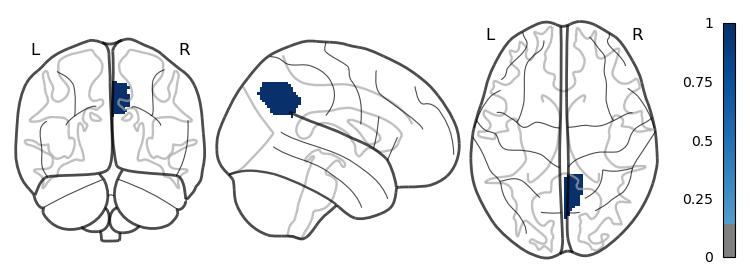

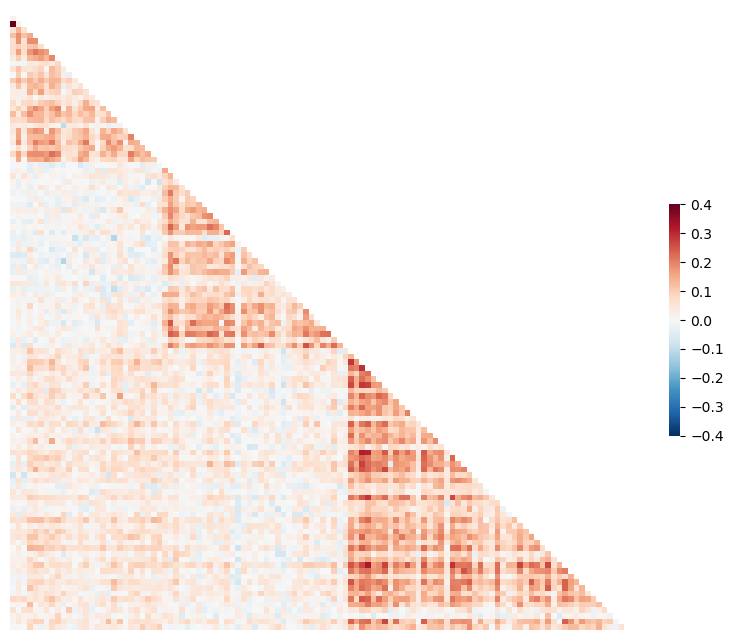

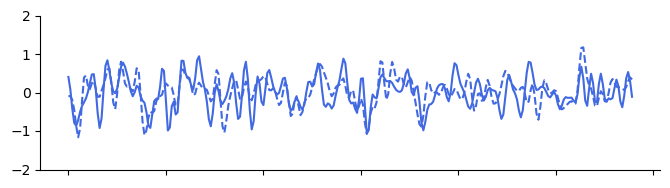

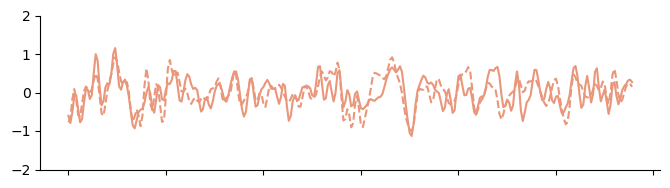

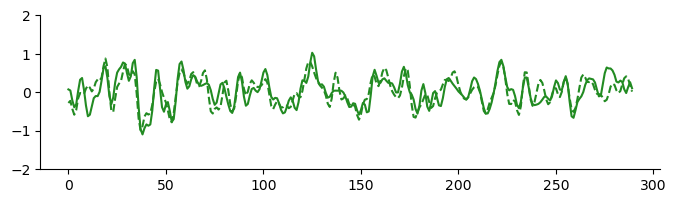

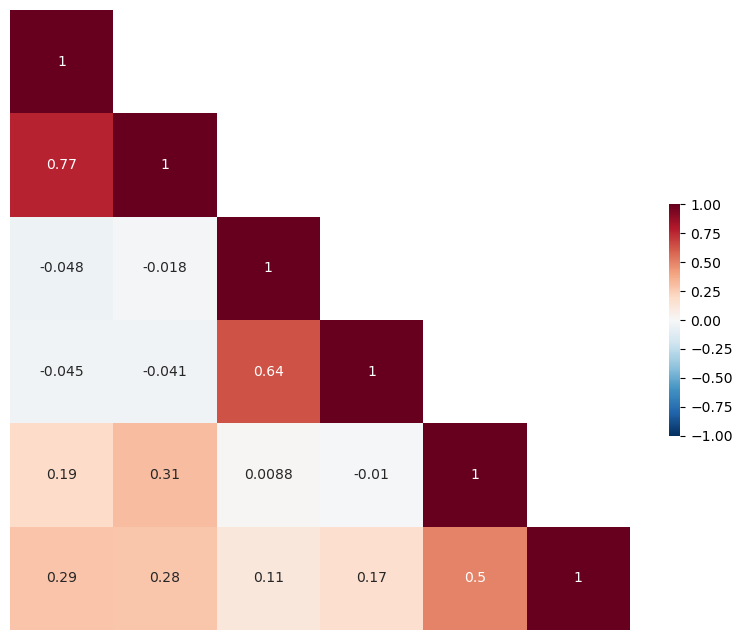

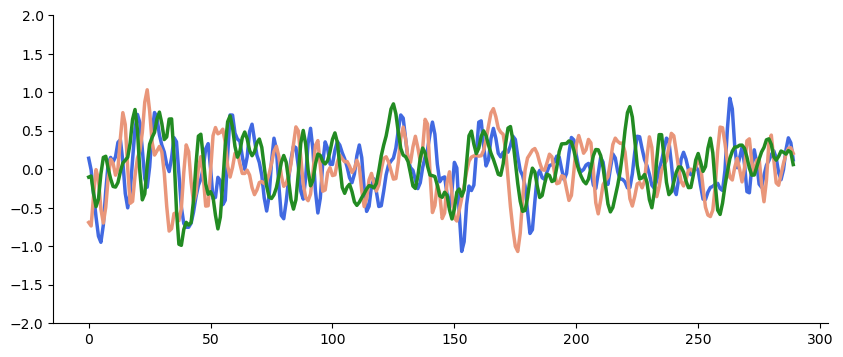

In [16]:
import seaborn as sns

roi = 89
print(d[roi+1])

curr_run  = 1 #the fourth run


r2       = np.zeros((1,293))
r2[0,roi] = 1
res_img  = all293_masker_reopened.inverse_transform(r2);
plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), 
                          colorbar=True, annotate = True,cmap="Blues", 
                          threshold=0.15,plot_abs=False, );

target_size = [291, 315, 338, 308, 283, 371, 340, 293, 368]
curr_target_size = target_size[curr_run]

data_fr = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppFR-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
data_cn = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppCN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
data_en = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppEN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
       
print(data_fr.shape)
print(data_cn.shape)
print(data_en.shape)

all_data = np.concatenate([data_fr, data_cn, data_en], axis =2)

print(result_all[ :,:].shape)


resmat = squareform(result_all[:,roi])
v_val = 0.4

f, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(resmat, dtype=bool))

sns.heatmap(resmat, mask=mask, cmap = "RdBu_r", 
            vmax= v_val, 
            #center= 0, 
            vmin = -v_val,
            square=True, 
            linewidths=.00, 
            cbar_kws={"shrink": .3})
plt.xticks([]);
plt.yticks([]);


#####################
print(roi)

target_size = [291, 315, 338, 308, 283, 371, 340, 293, 368]
curr_target_size = target_size[curr_run]

data_en = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppEN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
data_fr = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppFR-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
data_cn = np.load("../../data_lpp/fmri_data/extract_ts/lpp_alllang_allruns_fmri_resampled/task-lppCN-run-0" + str(curr_run+1) + "_resampled" + str(curr_target_size) + ".npy")
print(data_en.shape)
print(data_fr.shape)
print(data_cn.shape)

fr_half = int(data_fr.shape[2]/2)
print(fr_half)
    
cn_half = int(data_cn.shape[2]/2)
print(cn_half)
    
en_half = int(data_en.shape[2]/2)
print(en_half)


fr1 = np.mean(data_fr[15:-10,:, :fr_half], axis=2)
fr2 = np.mean(data_fr[15:-10,:, fr_half:], axis=2)
fr_all = np.mean(data_fr[15:-10,:,:], axis=2)

cn1 = np.mean(data_cn[15:-10,:, :cn_half], axis=2)
cn2 = np.mean(data_cn[15:-10,:, cn_half:], axis=2)
cn_all = np.mean(data_cn[15:-10,:,:], axis=2)

en1 = np.mean(data_en[15:-10,:, :en_half], axis=2)
en2 = np.mean(data_en[15:-10,:, en_half:], axis=2)
en_all = np.mean(data_en[15:-10,:,:], axis=2)

    
plt.figure(figsize = (8,2))
plt.plot(fr1[:,roi], color='royalblue');
plt.plot(fr2[:,roi], color='royalblue', linestyle = 'dashed');
plt.ylim([-2,2])
a = plt.gca()
xax = a.set_xticklabels([])
sns.despine()
    
print(np.corrcoef(fr1[:,roi], fr2[:,roi])[0,1])
       
plt.figure(figsize = (8,2))
plt.plot(cn1[:,roi], color='darksalmon');
plt.plot(cn2[:,roi], color='darksalmon', linestyle = 'dashed');
plt.ylim([-2,2])
a = plt.gca()
xax = a.set_xticklabels([])
sns.despine()
    
print(np.corrcoef(cn1[:,roi], cn2[:,roi])[0,1])
    
plt.figure(figsize = (8,2))
plt.plot(en1[:,roi], color='forestgreen');
plt.plot(en2[:,roi], color='forestgreen', linestyle = 'dashed');
#plt.title('Run' + str(curr_run+1))
plt.ylim([-2,2])
sns.despine()
print(np.corrcoef(en1[:,roi], en2[:,roi])[0,1])
  
    
allr = np.stack([en1[:,roi], en2[:,roi], cn1[:,roi], cn2[:,roi], fr1[:,roi], fr2[:,roi]])
allr_corr = np.corrcoef(allr)

v_val = 1.
f, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(allr_corr, dtype=bool), k=1)
sns.heatmap(allr_corr, mask=mask, 
            cmap = "RdBu_r", vmax= v_val, vmin = -v_val,
            square=True, linewidths=.00, annot = True, cbar_kws={"shrink": .3},)
plt.xticks([]);
plt.yticks([]);


plt.figure(figsize = (10,4))
plt.plot(fr_all[:,roi], color='royalblue', linewidth = 2.5);
plt.plot(cn_all[:,roi], color='darksalmon', linewidth = 2.5);
plt.plot(en_all[:,roi], color='forestgreen', linewidth = 2.5);

plt.ylim([-2, 2])
#a = plt.gca()
#xax = a.set_xticklabels([])
sns.despine()

In [33]:
def p_from_null(observed, distribution,
                side='two-sided', exact=False,
                axis=None):
    """Compute p-value from null distribution
    Returns the p-value for an observed test statistic given a null
    distribution. Performs either a 'two-sided' (i.e., two-tailed)
    test (default) or a one-sided (i.e., one-tailed) test for either the
    'left' or 'right' side. For an exact test (exact=True), does not adjust
    for the observed test statistic; otherwise, adjusts for observed
    test statistic (prevents p-values of zero). If a multidimensional
    distribution is provided, use axis argument to specify which axis indexes
    resampling iterations.
    The implementation is based on the work in [PhipsonSmyth2010]_.
    .. [PhipsonSmyth2010] "Permutation p-values should never be zero:
       calculating exact p-values when permutations are randomly drawn.",
       B. Phipson, G. K., Smyth, 2010, Statistical Applications in Genetics
       and Molecular Biology, 9, 1544-6115.
       https://doi.org/10.2202/1544-6115.1585
    Parameters
    ----------
    observed : float
        Observed test statistic
    distribution : ndarray
        Null distribution of test statistic
    side : str, default:'two-sided'
        Perform one-sided ('left' or 'right') or 'two-sided' test
    axis: None or int, default:None
        Axis indicating resampling iterations in input distribution
    Returns
    -------
    p : float
        p-value for observed test statistic based on null distribution
    """

    if side not in ('two-sided', 'left', 'right'):
        raise ValueError("The value for 'side' must be either "
                         "'two-sided', 'left', or 'right', got {0}".
                         format(side))

    n_samples = len(distribution)

    if side == 'two-sided':
        # Numerator for two-sided test
        numerator = np.sum(np.abs(distribution) >= np.abs(observed), axis=axis)
    elif side == 'left':
        # Numerator for one-sided test in left tail
        numerator = np.sum(distribution <= observed, axis=axis)
    elif side == 'right':
        # Numerator for one-sided test in right tail
        numerator = np.sum(distribution >= observed, axis=axis)

    # If exact test all possible permutations and do not adjust
    if exact:
        p = numerator / n_samples

    # If not exact test, adjust number of samples to account for
    # observed statistic; prevents p-value from being zero
    else:
        p = (numerator + 1) / (n_samples + 1)

    return p